# Práctica Series temporales

Se usarán **dos series de bolsa: IAG y Banco de Santander**

1.- **Elegir entre los ficheros** 'iag_2021.csv' y 'santander_2021.csv' y **cargar** uno de ellos

2.- **Detectar la columna que lleva la fecha y cargar el fichero de nuevo indicando la columna que contiene la información temporal**.

3.- **Definir el time series y comprobar si la serie es estacionaria o cómo de lejos está de serlo.**

4.- **Modelizar la tendencia de la serie**

5.- **Extraer las componentes tendencia, estacionalidad y residuo**.

6.- **Modelizar la componente estacionaria (calcula su performance rmse).**

7.- **Repetir el proceso con la otra serie y discutir resultados**

8.- **Modelizar la serie temporal completa usando el residuo como función generadora**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Importación del fichero

In [4]:
file='santander_2021.csv'
data = pd.read_csv(file) # Se especifica la función a aplicar sobre el objeto fecha
data.head()

,timestamp,hora,ultimo,volumen
0,1.609747e+09,2021-01-04 09:00:26,2.592,1005081
1,1.609747e+09,2021-01-04 09:00:28,2.592,1060093
2,1.609747e+09,2021-01-04 09:00:30,2.589,1076406
3,1.609747e+09,2021-01-04 09:00:31,2.589,1077906
4,1.609747e+09,2021-01-04 09:00:33,2.589,1080910


**Debemos utilizar la columna 'hora' como fecha del dataset y ponerlo de index.

# 2. Poniendo la fecha como index

In [11]:
data=pd.read_csv(file,parse_dates=['hora'],index_col=['hora'])

In [12]:
data.index # COMPROBAMOS QUE INDEX ESTÁ EN FORMATO DATETIME

DatetimeIndex(['2021-01-04 09:00:26', '2021-01-04 09:00:28',
               '2021-01-04 09:00:30', '2021-01-04 09:00:31',
               '2021-01-04 09:00:33', '2021-01-04 09:00:35',
               '2021-01-04 09:00:36', '2021-01-04 09:00:38',
               '2021-01-04 09:00:40', '2021-01-04 09:00:41',
               ...
               '2021-05-14 17:29:40', '2021-05-14 17:29:43',
               '2021-05-14 17:29:45', '2021-05-14 17:29:47',
               '2021-05-14 17:29:49', '2021-05-14 17:29:51',
               '2021-05-14 17:29:53', '2021-05-14 17:29:55',
               '2021-05-14 17:29:57', '2021-05-14 17:29:59'],
              dtype='datetime64[ns]', name='hora', length=1442144, freq=None)

# 3.- Comprobando estacionariedad de la serie

In [13]:
ts = data['ultimo'] # El time series es una serie pandas.
type(ts)

pandas.core.series.Series

In [20]:
print('Primera y última fechas:',ts.index[0],ts.index[-1])
print(ts.head(10))
print()
print(ts.tail(10))

Primera y última fechas: 2021-01-04 09:00:26 2021-05-14 17:29:59
hora
2021-01-04 09:00:26    2.5920
2021-01-04 09:00:28    2.5920
2021-01-04 09:00:30    2.5890
2021-01-04 09:00:31    2.5890
2021-01-04 09:00:33    2.5890
2021-01-04 09:00:35    2.5835
2021-01-04 09:00:36    2.5890
2021-01-04 09:00:38    2.5890
2021-01-04 09:00:40    2.5750
2021-01-04 09:00:41    2.5750
Name: ultimo, dtype: float64

hora
2021-05-14 17:29:40    3.3585
2021-05-14 17:29:43    3.3555
2021-05-14 17:29:45    3.3560
2021-05-14 17:29:47    3.3585
2021-05-14 17:29:49    3.3585
2021-05-14 17:29:51    3.3585
2021-05-14 17:29:53    3.3585
2021-05-14 17:29:55    3.3565
2021-05-14 17:29:57    3.3565
2021-05-14 17:29:59    3.3565
Name: ultimo, dtype: float64


El sampling está hecho a veces a dos segundos y otras veces a uno. Consideremos que el intervalo medio es de alrededor de 1.5 segundos.

Una jornada de cotización empieza a las 9:00 y cierra a las 17:30, que son 8:30 horas, que con un sampling promedio de 1.5 segundos tendrá del orden de 8.5 horas * 60 minutos * 40 samples por minuto=**20400 valores por día**

In [71]:
window=int(round(8.5*60*35,0)) # Usamos como ventana un día completo
ts.index[0]

Timestamp('2021-01-04 09:00:26')

In [83]:
ts.index[window]

Timestamp('2021-01-04 17:23:56')

In [84]:
ts.index[4*window]

Timestamp('2021-01-08 09:10:38')

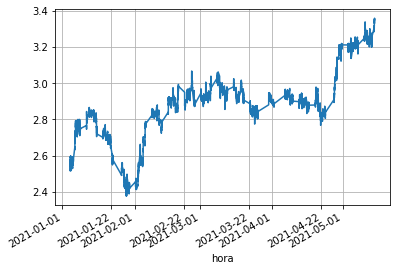

In [21]:
ts.plot(grid=True) 

## Inspección visual de media y desviación móviles

AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)


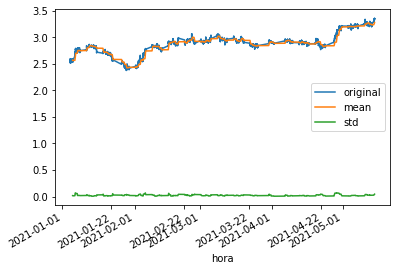

In [86]:
rol_mean=ts.rolling(window=window).mean()
rol_std=ts.rolling(window=window).std()
print(ts.plot(label='original',legend=True))
print(rol_mean.plot(label='mean',legend=True))
print(rol_std.plot(label='std',legend=True))

## Test Dickey-Fuller (DF)


[Reference](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

   - Este test considera como **hipótesis nula** que **la serie es no estacionaria**.

   - **Para aceptar la hipótesis nula** (serie no estacionaria) **el estadístico** (primer valor del resultado) **ha de ser mayor que los valores críticos**.

   - **Otro criterio** para acepatar la hipótesis nula es que el **p-value sea mayor que 0.05** (95% de confianza).



Dado que el fichero es muy largo debemos **partir la serie en tramos**. Procedemos a dividir por días (20400 samples por día)

Tramo 0
(-2.362541076924599, 0.15258914565133408, 46, 20353, {'1%': -3.430671334689482, '5%': -2.8616820187748715, '10%': -2.5668455926897287}, -237678.4225142868)

Estadístico -2.362541076924599
P-value 0.15258914565133408
Valores críticos {'1%': -3.430671334689482, '5%': -2.8616820187748715, '10%': -2.5668455926897287}

Tramo 1
(0.9003454574826298, 0.9930948329857444, 46, 20353, {'1%': -3.430671334689482, '5%': -2.8616820187748715, '10%': -2.5668455926897287}, -233344.23013893215)

Estadístico 0.9003454574826298
P-value 0.9930948329857444
Valores críticos {'1%': -3.430671334689482, '5%': -2.8616820187748715, '10%': -2.5668455926897287}

Tramo 2
(-1.9460348276340356, 0.3107241693908847, 46, 20353, {'1%': -3.430671334689482, '5%': -2.8616820187748715, '10%': -2.5668455926897287}, -236676.91570088055)

Estadístico -1.9460348276340356
P-value 0.3107241693908847
Valores críticos {'1%': -3.430671334689482, '5%': -2.8616820187748715, '10%': -2.5668455926897287}

Tramo 3
(-1.6865390681272154

(-2.7369955940220603, 0.06785226940581851, 33, 20366, {'1%': -3.430671129549658, '5%': -2.8616819281150963, '10%': -2.566845544433171}, -260059.19999982137)

Estadístico -2.7369955940220603
P-value 0.06785226940581851
Valores críticos {'1%': -3.430671129549658, '5%': -2.8616819281150963, '10%': -2.566845544433171}

Tramo 27
(-1.3001448629545427, 0.6291060360971286, 45, 20354, {'1%': -3.4306713189001914, '5%': -2.861682011796931, '10%': -2.566845588975497}, -252515.38186254702)

Estadístico -1.3001448629545427
P-value 0.6291060360971286
Valores críticos {'1%': -3.4306713189001914, '5%': -2.861682011796931, '10%': -2.566845588975497}

Tramo 28
(-1.311694930198551, 0.6238050293646396, 35, 20364, {'1%': -3.4306711610925813, '5%': -2.8616819420552195, '10%': -2.566845551853246}, -248776.6643573799)

Estadístico -1.311694930198551
P-value 0.6238050293646396
Valores críticos {'1%': -3.4306711610925813, '5%': -2.8616819420552195, '10%': -2.566845551853246}

Tramo 29
(-1.5680261761282175, 0.499

(-1.3990657134215423, 0.5827239451998627, 46, 20353, {'1%': -3.430671334689482, '5%': -2.8616820187748715, '10%': -2.5668455926897287}, -249932.2785892996)

Estadístico -1.3990657134215423
P-value 0.5827239451998627
Valores críticos {'1%': -3.430671334689482, '5%': -2.8616820187748715, '10%': -2.5668455926897287}

Tramo 53
(-3.069025403171007, 0.028931997118104305, 43, 20356, {'1%': -3.430671287326264, '5%': -2.8616819978431063, '10%': -2.566845581548129}, -257350.88566990255)

Estadístico -3.069025403171007
P-value 0.028931997118104305
Valores críticos {'1%': -3.430671287326264, '5%': -2.8616819978431063, '10%': -2.566845581548129}

Tramo 54
(-2.4325132440005364, 0.13276923989925604, 42, 20357, {'1%': -3.4306712715416268, '5%': -2.8616819908672224, '10%': -2.566845577834992}, -257001.33819147496)

Estadístico -2.4325132440005364
P-value 0.13276923989925604
Valores críticos {'1%': -3.4306712715416268, '5%': -2.8616819908672224, '10%': -2.566845577834992}

Tramo 55
(-1.1993618951217675,

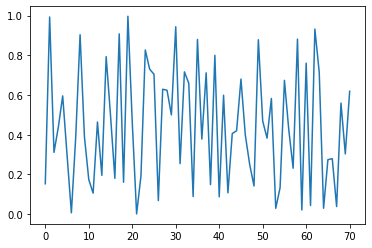

In [87]:
from statsmodels.tsa.stattools import adfuller as df

n_tramos=int(round(len(ts)/window,0)) #Número de tramos

pvalues=[]

for cont in range(0,n_tramos): 
    print('Tramo',cont)
    ts_temp=ts[cont*window:(cont+1)*window]
    result=df(ts_temp,autolag='AIC')
    print(result)
    print()
    print('Estadístico',result[0])
    pvalues.append(result[1])
    print('P-value',result[1])
    print('Valores críticos',result[4])
    print()
plt.plot(pvalues)
plt.grid()
plt.show()

**Se comprueba cuantitativamente que en promedio la serie no es estacionaria dentro de las ventanas diarias para muchos de los días. Sin embargo durante algunos días la serie sí se acerca a la estacionariedad.**

# 4. Modelización de la tendencia

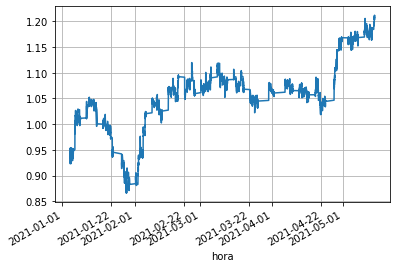

In [92]:
ts_log=np.log(ts)
trend=ts_log.ewm(alpha=0.1).mean().plot(grid=True)

# 5.- Descomposición de componentes

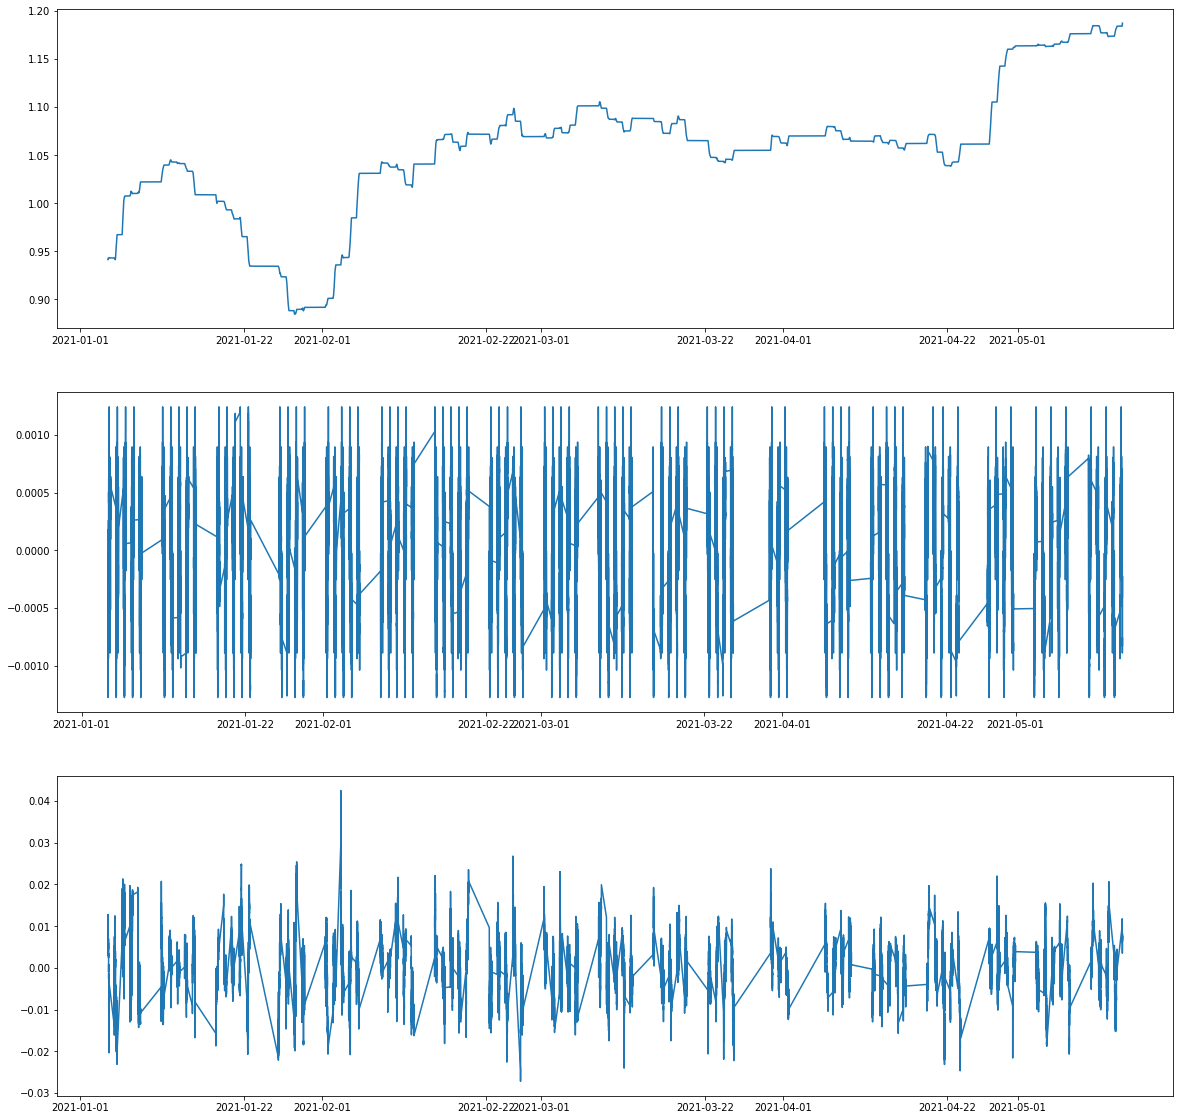

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose as decompose
result=decompose(ts_log,freq=window) 
trend=result.trend
season=result.seasonal
residuo=result.resid
plt.figure(figsize=(20,20))
plt.subplot(311)
plt.plot(trend)
plt.subplot(312)
plt.plot(season)
plt.subplot(313)
plt.plot(residuo)

# 6. Modelización del residuo

Tramo 0


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


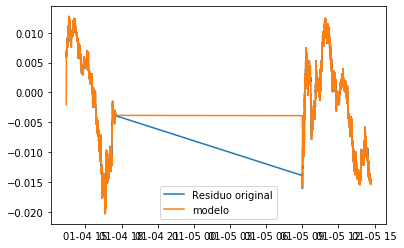

const          -0.002097
ar.L1.ultimo    1.902803
ar.L2.ultimo   -0.899106
ar.L3.ultimo   -0.003719
ma.L1.ultimo   -0.930702
dtype: float64

Tramo 1


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


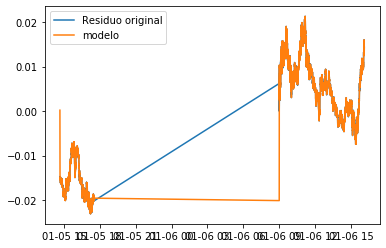

const           0.000197
ar.L1.ultimo    0.177969
ar.L2.ultimo    0.709923
ar.L3.ultimo    0.111619
ma.L1.ultimo    0.679038
dtype: float64

Tramo 2


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


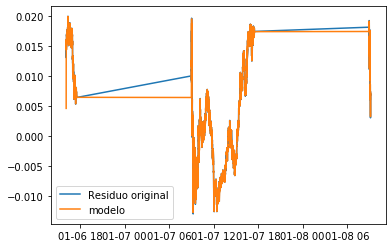

const           0.004649
ar.L1.ultimo    1.716806
ar.L2.ultimo   -0.741394
ar.L3.ultimo    0.024507
ma.L1.ultimo   -0.766059
dtype: float64

Tramo 3


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


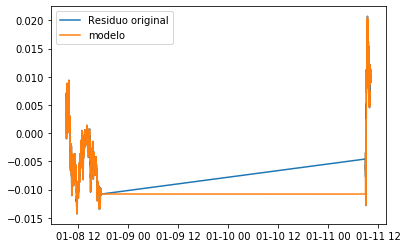

const           0.000166
ar.L1.ultimo    1.791707
ar.L2.ultimo   -0.768278
ar.L3.ultimo   -0.023477
ma.L1.ultimo   -0.867897
dtype: float64

Tramo 4


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


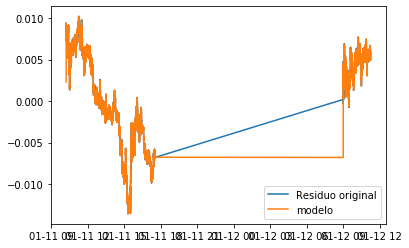

const           0.002314
ar.L1.ultimo    1.839783
ar.L2.ultimo   -0.812998
ar.L3.ultimo   -0.026829
ma.L1.ultimo   -0.903056
dtype: float64

Tramo 5


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


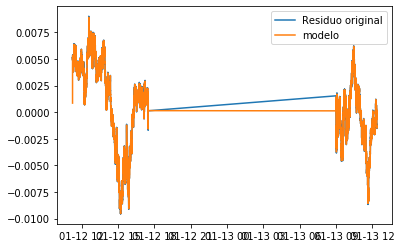

const           0.000849
ar.L1.ultimo    1.864989
ar.L2.ultimo   -0.846981
ar.L3.ultimo   -0.018061
ma.L1.ultimo   -0.932209
dtype: float64

Tramo 6


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


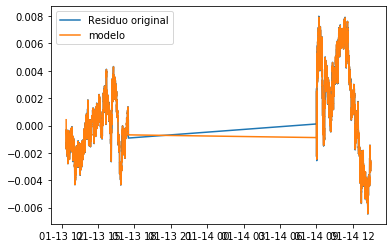

const           0.000426
ar.L1.ultimo    1.863937
ar.L2.ultimo   -0.839664
ar.L3.ultimo   -0.024339
ma.L1.ultimo   -0.927182
dtype: float64

Tramo 7


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


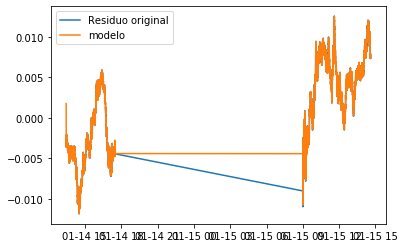

const           0.001776
ar.L1.ultimo    1.887668
ar.L2.ultimo   -0.889678
ar.L3.ultimo    0.001981
ma.L1.ultimo   -0.919224
dtype: float64

Tramo 8


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


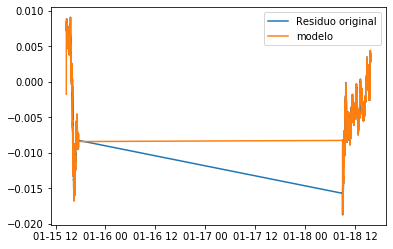

const          -0.001724
ar.L1.ultimo    1.834661
ar.L2.ultimo   -0.823216
ar.L3.ultimo   -0.011504
ma.L1.ultimo   -0.875277
dtype: float64

Tramo 9


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


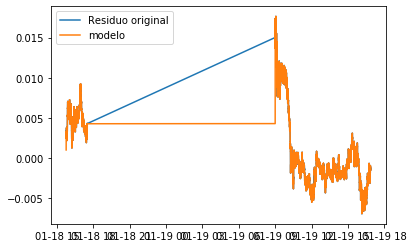

const           0.001008
ar.L1.ultimo    0.696103
ar.L2.ultimo    0.275157
ar.L3.ultimo    0.027861
ma.L1.ultimo    0.287416
dtype: float64

Tramo 10


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


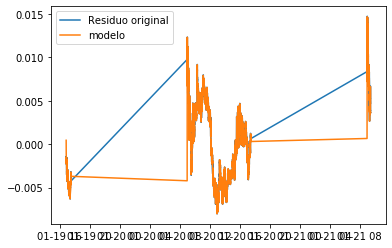

const           0.000456
ar.L1.ultimo    1.556454
ar.L2.ultimo   -0.581059
ar.L3.ultimo    0.024187
ma.L1.ultimo   -0.590747
dtype: float64

Tramo 11


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


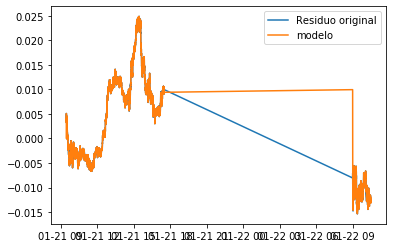

const           0.000090
ar.L1.ultimo    1.518838
ar.L2.ultimo   -0.551789
ar.L3.ultimo    0.032840
ma.L1.ultimo   -0.552320
dtype: float64

Tramo 12


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


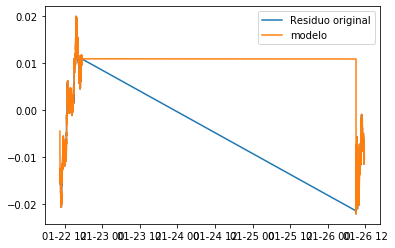

const          -0.004555
ar.L1.ultimo    1.496915
ar.L2.ultimo   -0.511222
ar.L3.ultimo    0.014085
ma.L1.ultimo   -0.516144
dtype: float64

Tramo 13


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


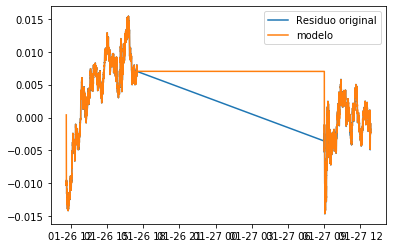

const           0.000398
ar.L1.ultimo    1.881531
ar.L2.ultimo   -0.863743
ar.L3.ultimo   -0.017829
ma.L1.ultimo   -0.918333
dtype: float64

Tramo 14


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


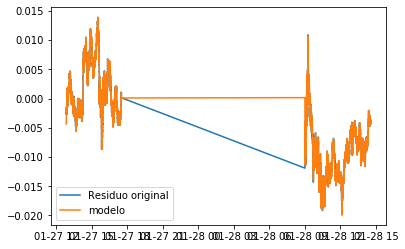

const          -0.004351
ar.L1.ultimo    1.707052
ar.L2.ultimo   -0.685380
ar.L3.ultimo   -0.021820
ma.L1.ultimo   -0.801347
dtype: float64

Tramo 15


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


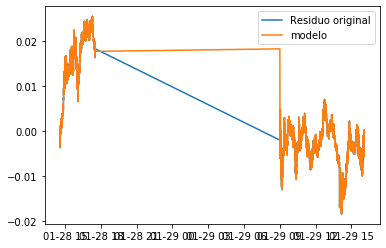

const           0.001136
ar.L1.ultimo    1.759427
ar.L2.ultimo   -0.754694
ar.L3.ultimo   -0.004830
ma.L1.ultimo   -0.796473
dtype: float64

Tramo 16


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


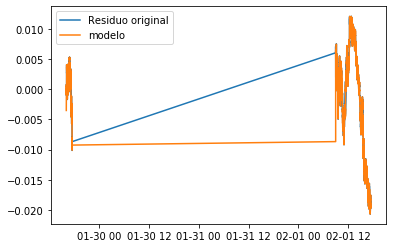

const          -0.003528
ar.L1.ultimo    1.864378
ar.L2.ultimo   -0.902862
ar.L3.ultimo    0.038451
ma.L1.ultimo   -0.868233
dtype: float64

Tramo 17


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


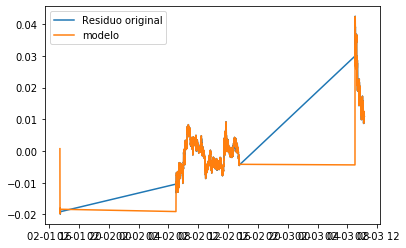

const           0.000728
ar.L1.ultimo    1.185163
ar.L2.ultimo   -0.199982
ar.L3.ultimo    0.014308
ma.L1.ultimo   -0.260315
dtype: float64

Tramo 18


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


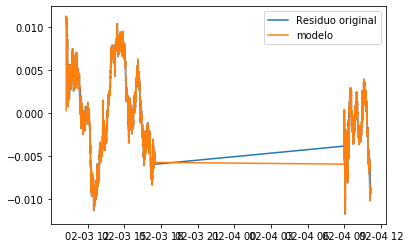

const           0.000284
ar.L1.ultimo    1.801282
ar.L2.ultimo   -0.781821
ar.L3.ultimo   -0.019538
ma.L1.ultimo   -0.850597
dtype: float64

Tramo 19


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


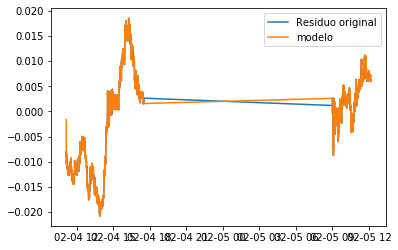

const          -0.001639
ar.L1.ultimo    1.805339
ar.L2.ultimo   -0.803811
ar.L3.ultimo   -0.001564
ma.L1.ultimo   -0.847317
dtype: float64

Tramo 20


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


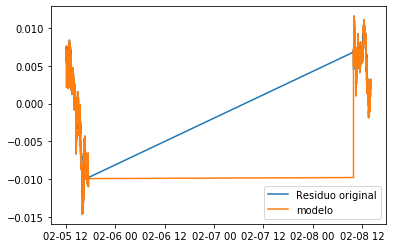

const           0.002144
ar.L1.ultimo    1.144159
ar.L2.ultimo   -0.138222
ar.L3.ultimo   -0.006402
ma.L1.ultimo   -0.163732
dtype: float64

Tramo 21


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


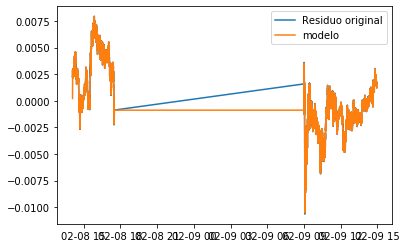

const           0.000207
ar.L1.ultimo    1.854191
ar.L2.ultimo   -0.857191
ar.L3.ultimo    0.002893
ma.L1.ultimo   -0.896450
dtype: float64

Tramo 22


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


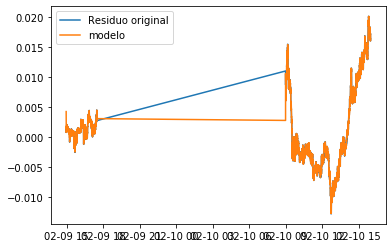

const           0.004231
ar.L1.ultimo    1.843755
ar.L2.ultimo   -0.815964
ar.L3.ultimo   -0.027809
ma.L1.ultimo   -0.898738
dtype: float64

Tramo 23


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


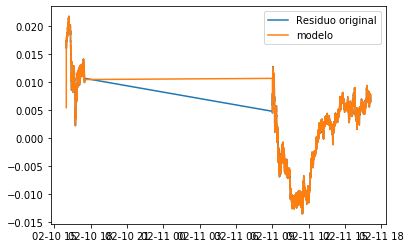

const           0.005397
ar.L1.ultimo    1.808581
ar.L2.ultimo   -0.817558
ar.L3.ultimo    0.008949
ma.L1.ultimo   -0.837999
dtype: float64

Tramo 24


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


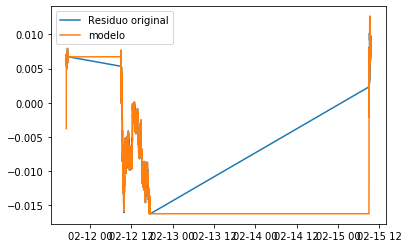

const          -0.003783
ar.L1.ultimo    1.047418
ar.L2.ultimo   -0.067151
ar.L3.ultimo    0.019258
ma.L1.ultimo   -0.164557
dtype: float64

Tramo 25


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


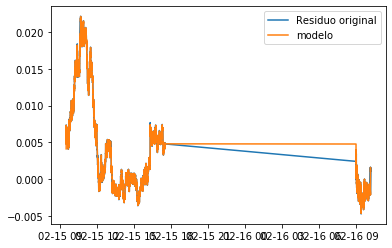

const           0.004111
ar.L1.ultimo    1.797448
ar.L2.ultimo   -0.807092
ar.L3.ultimo    0.009604
ma.L1.ultimo   -0.856053
dtype: float64

Tramo 26


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

In [95]:
from statsmodels.tsa.arima_model import ARIMA as arima

residuo=residuo.dropna()
order=(3,0,1)
n_tramos=int(round(len(ts)/window,0)) #Número de tramos

models=[]

for cont in range(0,n_tramos): 
    print('Tramo',cont)
    residuo_temp=residuo[cont*window:(cont+1)*window]
    modelo=arima(residuo_temp,order=order)
    results=modelo.fit()
    plt.plot(residuo_temp,label='Residuo original')
    plt.plot(results.fittedvalues,label='modelo')
    plt.legend()
    plt.show()
    models.append(results.fittedvalues)
    print(results.params)
    print()


# 8. Forecasting de la serie temporal global usando la componente estacionaria como función generadora

PROCEDIMIENTO:

1.- División de la serie en serie_training y serie_testing.

2.- Extracción de la serie estracionaria de ts_tr.

3.- Extracción de la señal generadora de ts_tr

4.- Ajuste de ts_tr usando una regresión lineal que usa como input la señal generadora.

5.- Uso del valor óptimo de lag y la regresión lineal entrenada con ts_tr para predecir valores futuros en ts_test

    

## 1.- División de la serie en training y testing datasets

In [106]:
porcentaje_en_ts_tr=0.05 #Trozo que queremos como dataset de training
lentgh=len(ts)
corte=int(porcentaje_en_ts_tr*lentgh) # Decidimos utilizar un 60% para training
'''
Cortamos la serie en dos
'''
ts_tr=ts[0:corte]
ts_test=ts[corte+1:]
print('Puntos en ts_tr',len(ts_tr))
print('Puntos en ts_test',len(ts_test))

Puntos en ts_tr 72107
Puntos en ts_test 1370036


## 2 .- Extracción de la serie estracionaria de ts_tr

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose as decompose
'''
Primero suavizamos la serie
'''
ts_log_tr=np.log(ts_tr)

'''
Extraemos el residuo
'''
out=decompose(ts_log_tr,freq=window)
residuo_tr=out.resid

'''
Se crea un dataframe pandas para ir poniendo los resultados de las diferentes componentes
'''
df_tr=pd.DataFrame(data=ts_log_tr.values,index=ts_log_tr.index,columns=['ts_log'])
df_tr['residuo']=residuo_tr.values
df_tr['serie']=ts_tr.values
df_tr=df_tr.dropna()

## 3.- Extracción de la señal generadora de ts_tr

In [109]:
from statsmodels.tsa.arima_model import ARIMA as arima

model_order=(2,0,1) #Definimos un modelo
model=arima(df_tr['residuo'].values,order=model_order) 
model=model.fit() #Modelo ajustado
estimaciones=model.fittedvalues
df_tr['est_residuo']=estimaciones

In [110]:
'''
Calculamos el error cuadrático medio de la estimación de la serie estacionaria
'''
df_tr['error']=df_tr['residuo']-df_tr['est_residuo']
df_tr['error']=df_tr['error'].apply(lambda x: x**2)
rmse=df_tr['error'].mean()
rmse=np.sqrt(rmse)
print('Error cuadrático medio:',rmse)

Error cuadrático medio: 0.0002326033431694739


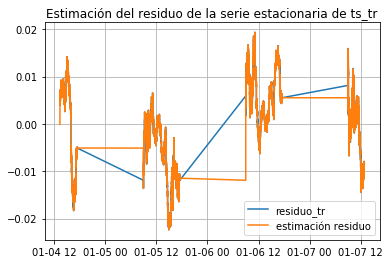

In [111]:
plt.plot(df_tr['residuo'],label='residuo_tr')
plt.plot(df_tr['est_residuo'],label='estimación residuo')
plt.title('Estimación del residuo de la serie estacionaria de ts_tr')
plt.legend()
plt.grid()
plt.show()

In [112]:
#Calculamos el acumulado de las estimaciones en una columna diferente
df_tr['est_cumsum']=df_tr['est_residuo'].cumsum() #Acumulado de las estimaciones
df_tr.head()

,ts_log,residuo,serie,est_residuo,error,est_cumsum
hora,,,,,,
2021-01-04 13:24:44,0.947789,0.004329,2.5800,-0.000132,1.990300e-05,-0.000132
2021-01-04 13:24:45,0.947789,0.004211,2.5800,0.004328,1.366740e-08,0.004195
2021-01-04 13:24:47,0.947596,0.004083,2.5795,0.004219,1.857148e-08,0.008415
2021-01-04 13:24:48,0.947983,0.004343,2.5805,0.004095,6.135205e-08,0.012509
2021-01-04 13:24:50,0.947983,0.004344,2.5805,0.004322,4.775632e-10,0.016831


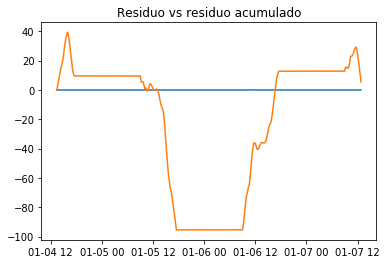

In [113]:
plt.plot(df_tr['residuo'])
plt.plot(df_tr['est_cumsum'])
plt.title('Residuo vs residuo acumulado')
plt.show()

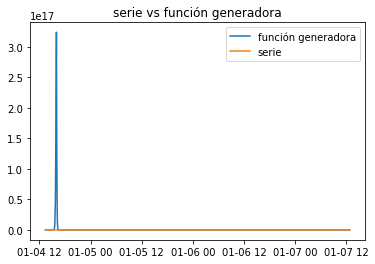

In [114]:
# SE SUMA RESIDUO (estimado) ACUMULADO A LA SERIE_LOG y se deshace la transformación lograrítmica.
#  el resultado se considera la FUNCIÓN GENERADORA

df_tr['est_log']=df_tr['ts_log']+df_tr['est_cumsum']
df_tr['est_serie']=np.exp(df_tr['est_log'].values)
plt.plot(df_tr['est_serie'],label='función generadora')
plt.plot(df_tr['serie'],label='serie')
plt.legend()
plt.title('serie vs función generadora')
plt.show()


## 4.- Ajuste de ts_tr usando una regresión lineal que usa como input la señal generadora

### 4.1 Ajuste de la serie training para un lag dado

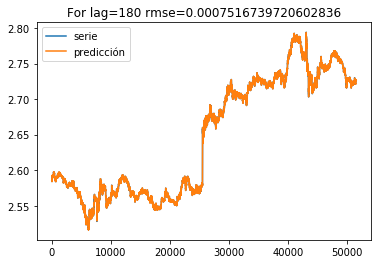

In [118]:
from sklearn.linear_model import LinearRegression as reg

x=[]
y=[]

feat_input='serie' #Seleccionamos la variable de entrada para el modelo
lag=180 #Seleccionamos retraso temporal para el modelo

for k in range(lag,len(df_tr)):
    x_value=df_tr[feat_input].iloc[k-lag:k].ravel()
    y_value=df_tr['serie'].iloc[k]
    x.append(x_value)
    y.append(y_value)
regresion=reg()
regresion.fit(x,y)
pred=regresion.predict(x)
rmse=np.mean((y-pred)**2)
rmse=np.sqrt(rmse)

plt.plot(y,label='serie')
plt.title('For lag='+str(lag)+' rmse='+str(rmse))
plt.plot(pred,label='predicción')
plt.legend()
plt.show()







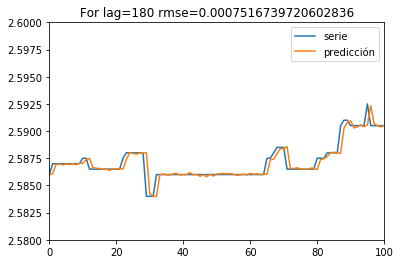

In [124]:
#ZOOM
plt.plot(y,label='serie')
plt.title('For lag='+str(lag)+' rmse='+str(rmse))
plt.xlim(0,100)
plt.ylim(2.58,2.6)
plt.plot(pred,label='predicción')
plt.legend()
plt.show()


**El modelo reacciona tarde en cambios bruscos de tendencia**

### 4.2 Iteramos sobre varios valores de lag para ver cómo varía rsme

In [116]:
#DEFINIMOS UNA FUNCIÓN QUE CALCULE RMSE EN FUNCIÓN DEL LAG.
def lag_finder(df,feat_input,target,lag):
    from sklearn.linear_model import LinearRegression as reg

    x=[]
    y=[]


    
    for k in range(lag,len(df_tr)):
        x_value=df[feat_input].iloc[k-lag:k].ravel()
        y_value=df[target].iloc[k]
        x.append(x_value)
        y.append(y_value)
    regresion=reg()
    regresion.fit(x,y)
    pred=regresion.predict(x)
    rmse=np.mean((y-pred)**2)
    rmse=np.sqrt(rmse)

    plt.plot(y,label='serie')
    plt.title('For lag='+str(lag)+' rmse='+str(rmse))
    plt.plot(pred,label='predicción')
    plt.legend()
    plt.show()
    return rmse


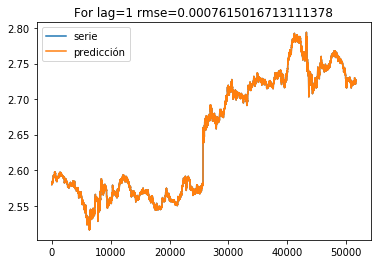

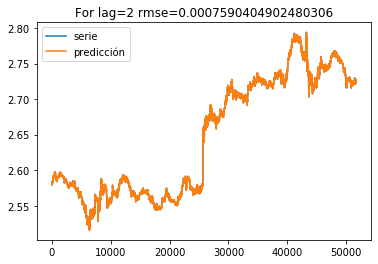

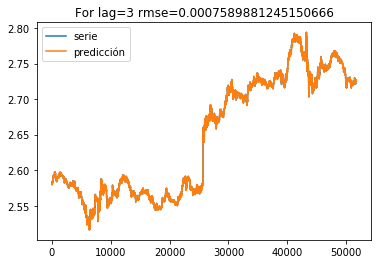

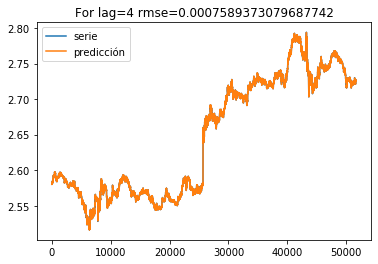

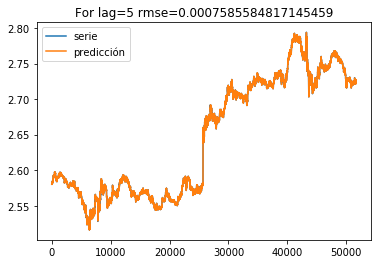

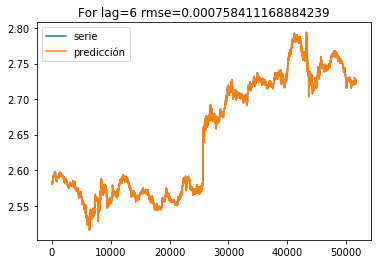

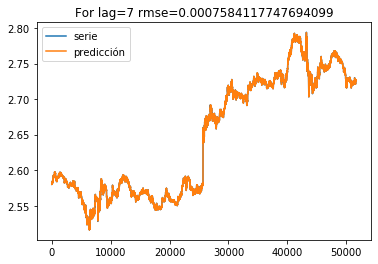

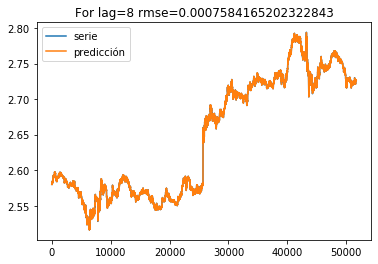

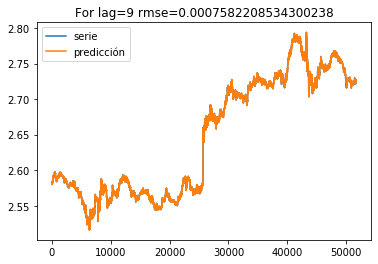

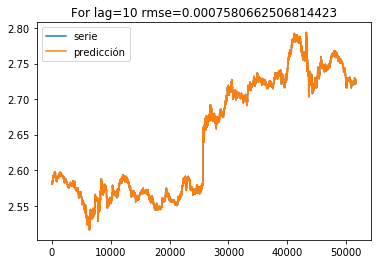

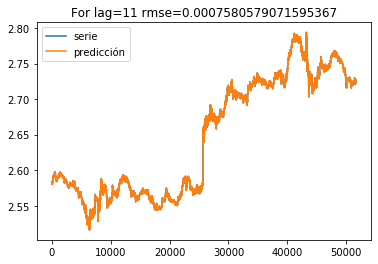

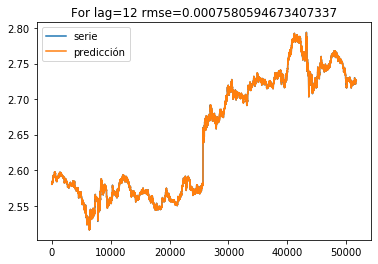

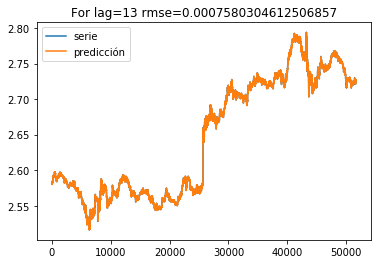

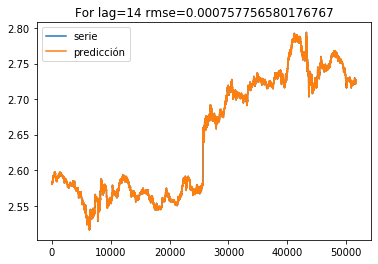

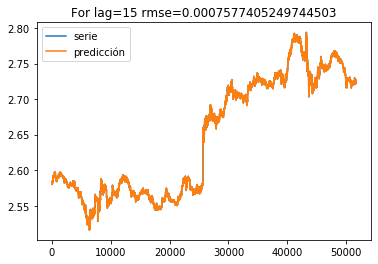

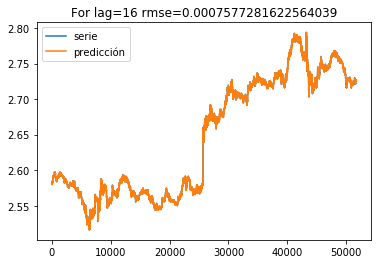

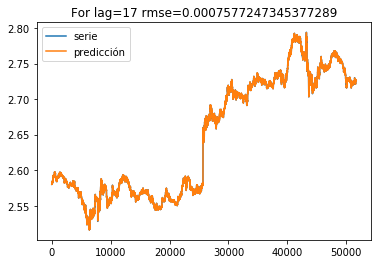

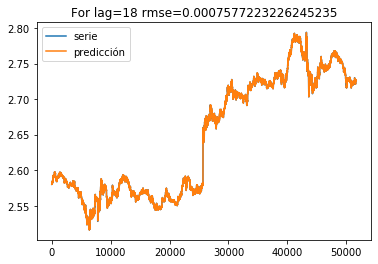

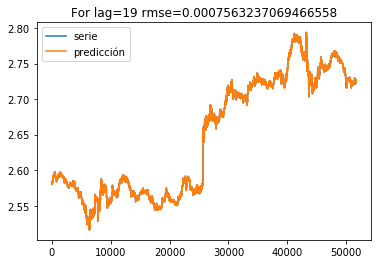

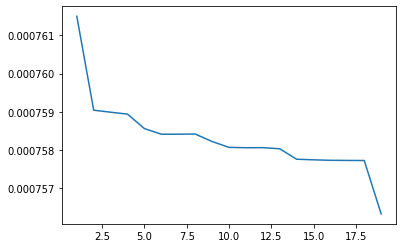

In [117]:

lags=[]
rmses=[]
target='serie'
for lag in range(1,20):
    out=lag_finder(df_tr,feat_input,target,lag)
    rmses.append(out)
    lags.append(lag)
plt.plot(lags,rmses)
plt.show()

## 5.- Uso del valor óptimo de lag y la regresión lineal entrenada con ts_tr para predecir valores futuros en ts_test

In [56]:
#DEFINIMOS UNA FUNCIÓN QUE CALCULE RMSE PARA UN LAG DADO,UNA SERIE GENÉRICA Y UN MODELO YA ENTRENADO.
def linear_model(x_serie,y_serie,lag,model):
   

    x=[]
    y=[]


    
    for k in range(0+lag,len(x_serie)):
        '''
        x_value=df_pred['est_serie'].iloc[k-lag:k].ravel()
        y_value=df_pred['serie'].iloc[k]
        '''
        
        x_value=x_serie.iloc[k-lag:k].ravel()
        y_value=y_serie.iloc[k]
        x.append(x_value)
        y.append(y_value)
   
    
    
    pred=model.predict(x)
    rmse=np.mean((y-pred)**2)
    rmse=np.sqrt(rmse)

    
    
    return [rmse,pred]

### Extracción de la señal generadora de la serie de testing

In [57]:
#Extraemos la señal generadora de la serie de testing
ts_log_test=np.log(ts_test)
residuo_test=decompose(ts_log_test).resid
'''
Definimos un dataframe (como hicimos para la serie de training)
'''
df_test=pd.DataFrame(ts_test.values,index=ts_test.index,columns=['serie'])
df_test['serie_log']=ts_log_test.values
df_test['residuo']=residuo_test
df_test=df_test.dropna()

model_order=(2,0,1) #Definimos el mismo modelo que usamos con la serie de training
model=arima(df_test['residuo'],order=model_order) 
model=model.fit() #Modelo ajustado
estimaciones_test=model.fittedvalues

df_test['est_residuo']=estimaciones_test

df_test['est_cumsum']=df_test['est_residuo'].cumsum() #Acumulado de las estimaciones
df_test['est_log']=df_test['serie_log']+df_test['est_cumsum']
df_test['est_serie']=np.exp(df_test['est_log'].values)




C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
x=[]
y=[]


lag=11 #MISMO LAG CON EL QUE HEMOS ENTRENADO EL MODELO PARA ts_tr

#OJO, ESTE MODELO TIENE QUE HABER SIDO ENTRENADO PREVIAMENTE CON EL LAG ÓPTIMO Y LA SERIE TRAINING
out=linear_model(df_test[feat_input],df_test['serie'],lag,regresion) 
rmse=out[0]
pred=out[1]


n_2_predict=len(df_test)-lag #Al predecir con retardos temporales perdemos un tramo inicial de la serie. Se predice sobre el tramo restante
df_result=pd.DataFrame(df_test['serie'].iloc[-n_2_predict:],index=df_test['serie'].iloc[-n_2_predict:].index)
df_result['pred']=pred
rmse=np.mean((df_test['serie'].iloc[-n_2_predict:]-df_result['pred'])**2)
rmse=np.sqrt(rmse)

plt.plot(df_result['serie'].values,label='serie')
plt.title('For lag='+str(lag)+' rmse='+str(rmse))
plt.plot(df_result['pred'].values,label='predicción')
plt.legend()
plt.show()
